In [35]:
from math import sqrt
import tensorflow as tf
import pandas as pd
from keras import Sequential
from keras.layers import LSTM, Dense, Conv1D
from keras.losses import mean_squared_error
from numpy.core._multiarray_umath import concatenate
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# supervised监督学习函数


def series_to_supervised(data, columns, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if isinstance(data, list) else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s%d(t-%d)' % (columns[j], j + 1, i))
                  for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s%d(t)' % (columns[j], j + 1)) for j in range(n_vars)]
        else:
            names += [('%s%d(t+%d)' % (columns[j], j + 1, i))
                      for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        clean_agg = agg.dropna()
    return clean_agg
    # return agg


dataset = pd.read_csv(
    'Machine_usage_groupby.csv')

dataset_columns = dataset.columns
values = dataset.values
print(dataset)

# 归一化处理
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


# 监督学习
reframed = series_to_supervised(scaled, dataset_columns, 1, 1)
values = reframed.values

# 学习与检测数据的划分
n_train_hours = 20000
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
print(train.shape)
print(test.shape)

# 监督学习结果划分
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)


# 为了在LSTM中应用该数据，需要将其格式转化为3D format，即[Samples, timesteps, features]
train_X = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_X = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
print(train_X.shape)
print(test_X.shape)

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=10,
                 strides=1, padding="causal",
                 activation="sigmoid"))
model.add(
    LSTM(
        64,
        input_shape=(
            train_X.shape[1],
            train_X.shape[2]),
        return_sequences=True))
model.add(LSTM(32, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(32, activation="relu"))
model.add(Dense(16, activation="relu"))
model.add(Dense(1))
model.compile(loss=tf.keras.losses.Huber(),
    optimizer='adam',
    metrics=["mae"])
history = model.fit(
    train_X,
    train_y,
    epochs=200,
    batch_size=72,
    validation_data=(
        test_X,
        test_y),
verbose = 2)

         Time  cpu_util_percent  ...  net_out  disk_usage_percent
0           0              12.0  ...    26.49                31.0
1         130              13.5  ...    28.63                 2.5
2         140               5.0  ...    18.12                 1.0
3         160              13.0  ...    30.09                 3.0
4         180               5.0  ...    18.12                 1.0
...       ...               ...  ...      ...                 ...
36211  691040              28.0  ...    41.75                 3.0
36212  691060              93.0  ...    38.37                 3.0
36213  691080              31.0  ...    35.73                 3.0
36214  691110              92.0  ...    38.37                 2.0
36215  691180              18.5  ...    38.47                 3.5

[36216 rows x 8 columns]
(20000, 16)
(16215, 16)
(20000, 15)
(20000,)
(16215, 15)
(16215,)
(20000, 1, 15)
(16215, 1, 15)
Train on 20000 samples, validate on 16215 samples
Epoch 1/200
 - 2s - loss: 0.0027 - m

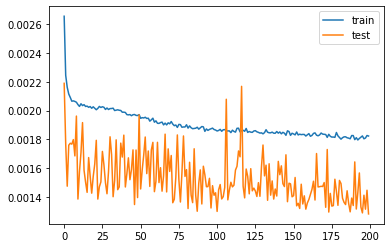

In [36]:

'''
    对数据绘图
'''
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


In [37]:
# make the prediction,为了在原始数据的维度上计算损失，需要将数据转化为原来的范围再计算损失
yHat = model.predict(test_X)
print(inv_yHat.shape)

inv_yHat = concatenate((yHat, test_x[:, 1:]), axis=1)   # 数组拼接
inv_yHat = inv_yHat[:, 0]

test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_x[:, 1:]), axis=1)
inv_y = inv_y[:, 0]

rmse = sqrt(mean_squared_error(inv_yHat, inv_y))
print('Test RMSE: %.3f' % rmse)

(16215,)
Test RMSE: 0.051
